# Анализ данных для интернет-магазина видеоигр

## Описание проекта
Провести анализ данных полученных из открытых источников до 2016 года:
- исторические данные о продажах игр
- оценки пользователей и экспертов
- жанры и платформы

**Задача проекта:**
- выявить закономерности определяющие успешность игры
- найти потенциально популярный продукт

## 1. Открываем файл с данными и изучаем общую информацию

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats as st

import statsmodels.api as sm

# from pandas_profiling import ProfileReport

     
from pylab import rcParams
rcParams['figure.figsize'] = 18,8

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

In [2]:
df = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\games.csv', sep=',')

In [3]:
# общая информация о таблице
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Описание данных

- **Name** — название игры
- **Platform** — платформа
- **Year_of_Release** — год выпуска
- **Genre** — жанр игры
- **NA_sales** — продажи в Северной Америке (миллионы проданных копий)
- **EU_sales** — продажи в Европе (миллионы проданных копий)
- **JP_sales** — продажи в Японии (миллионы проданных копий)
- **Other_sales** — продажи в других странах (миллионы проданных копий)
- **Critic_Score** — оценка критиков (максимум 100)
- **User_Score** — оценка пользователей (максимум 10)
- **Rating** — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). ESRB определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию. Данные за 2016 год могут быть неполными.

In [4]:
df.tail()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.0,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN
16714,Winning Post 8 2016,PSV,2016.0,Simulation,0.00,0.00,0.01,0.0,NaN,NaN,NaN


In [5]:
# определим в каких столбцах есть пропуски
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [6]:
# пропуски в процентах
pd.DataFrame(round(df.isna().mean()*100, 2)).rename(columns = {0:'Пропуски'}).sort_values(by = 'Пропуски', ascending = False).style.background_gradient('coolwarm')

,Пропуски
Critic_Score,51.320000
Rating,40.480000
User_Score,40.090000
Year_of_Release,1.610000
Name,0.010000
Genre,0.010000
Platform,0.000000
NA_sales,0.000000
EU_sales,0.000000
JP_sales,0.000000


### Обнаруженные проблемы

1. Наименование столбцов в разном реегистре.
2. Тип данных в столбце **"Year_of_Release"** нужно перевести в *datetime* и оставим только год (*year*).
3. Тип данных в **"User_Score"** должен быть с с плавающей точкой (*float64*).
4. Большое (относительно всего датасета) количество пропусков данных в столбцах: **"Critic_Score"**, **"User_Score"** и **"Rating"** 
5. Незначительное количество пропусков (относительно всего датасета) - **"Name"**, **"Year_of_Release"** и **"Genre"**                   

Поскольку нам неизвестно, как собирались данные из открытых источников, то можем предположить, что причинами пропусков являются:
1. изначальное отсутствие этих данных
2. ошибки ручного и/или автоматического парсинга
3. ошибки ручного и/или автоматического внесения данных

## 2. Подготовка данных

### 2.1 Заменим названия столбцов (приведем к нижнему регистру)

In [7]:
# приведем регистр в названиях столбцов к нижнему значению
df.columns = df.columns.str.lower()
# проверим изменения
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Удалим строки с пропущенными значениями в столбцах 'name', 'year_of_release' и 'genre'.

Имя игры и жанр корректно заполнить не сможем, к тому же таких пропусков всего по два.

Пропусков в годе релиза - 269, это всего датасета - 1,6%.
Корректно заполнить не сможем, удаление небольшого количества данных не должно повлиять на результат анализа.

In [8]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [9]:
# удалим строки, сборосим и перезапишем индексы строк
df = df.dropna(subset=['name','year_of_release','genre' ]).reset_index(drop=True)

### 2.2 Преобразуем данные в нужные типы

In [10]:
# переведем столбец 'year_of_release' в формат 'datetime' 
# оставим только значение год, так будет удобнее анализировать числовые значения
df['year_of_release'] = pd.to_datetime(df['year_of_release'], format='%Y').dt.year

In [11]:
# проверим уникальные значения в столбце "genre" и отсортируем их по возрастанию
df['genre'].sort_values().unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object)

In [12]:
# для удобствта данные в столбце 'genre' тоже приведм к нижнему регистру 
df['genre'] = df['genre'].str.lower()

In [13]:
# посмотрим 10 случайных строк
df.sample(20)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
13981,Trap Gunner: Countdown to Oblivion,PS,1998,strategy,0.02,0.01,0.00,0.00,NaN,NaN,NaN
4016,Alone in the Dark,X360,2008,adventure,0.14,0.30,0.00,0.05,58.0,5.7,M
13304,Cheer We Go!,DS,2010,misc,0.04,0.00,0.00,0.00,NaN,NaN,NaN
15246,Planetarium Creator Ohira Takayuki Kanshuu: Ho...,PSP,2006,misc,0.00,0.00,0.02,0.00,NaN,NaN,NaN
6023,Marvel Nemesis: Rise of the Imperfects,XB,2005,fighting,0.21,0.06,0.00,0.01,58.0,7.5,T
9898,Shin Sangoku Musou: Multi Raid 2,PSP,2010,action,0.00,0.00,0.11,0.00,NaN,NaN,NaN
13794,The Sum of All Fears,GBA,2002,shooter,0.03,0.01,0.00,0.00,69.0,tbd,T
7961,"The Chronicles of Narnia: The Lion, The Witch ...",DS,2005,action,0.15,0.01,0.00,0.01,65.0,7.5,E10+
12534,Tiger Woods PGA Tour 08,DS,2007,sports,0.05,0.00,0.00,0.00,81.0,7.6,E
9742,Jaws: Ultimate Predator,3DS,2011,action,0.11,0.00,0.00,0.01,NaN,tbd,M


In [14]:
# проверим уникальные значения в столбце "year_of_release" и отсортируем их по возрастанию
df['year_of_release'].sort_values().unique()

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016], dtype=int64)

Годы релизов - 1980-2016, отображаются корректно.

### 2.3 Обработаем пропуски

#### 2.3.1 Обработаем пропуски в столбце 'rating'

In [15]:
# проверим уникальные значения в столбце "rating"
df['rating'].sort_values().unique()

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', nan], dtype=object)

Обнаружены неявные дубликаты: рейтинг "K-A" ("Kids to Adults") - "Дети для взрослых" использовался до 1997 года, а с 1998 заменен на "E" ("Everyone") — "Для всех" (Wikipedia).

По смыслу это одинаковые рейтинги, поэтому для дальнейшего анализа заменим устаревшее значение рейтинга "K-A" на "E".

In [16]:
# заменим значения 'K-A' на 'E'
df['rating'] = df['rating'].replace('K-A', 'E')
df['rating'].value_counts()

E       3924
T       2905
M       1536
E10+    1393
EC         8
AO         1
RP         1
Name: rating, dtype: int64

Система ESRB основана в 1994 году и определяет рейтинги для компьютерных и видеоигр в США, Мексике и Канаде (Wikipedia).

В Европе и Японии используются собственная рейтинговая система. С этим различием и связано наличие пропусков в столбце "rating". Возможно, издатель не получал рейтинг ESRB, так как игра не выпускалась для региона Северная Америка. Игры вышедшие с 1980 по 1994 могут вообще не иметь оценку ESRB. Кроме того, возможна, банальная потеря данных при парсинге/сохранении в датасет.

Поскольку данные носят категорийный характер, то корректно мы их не заполним, поэтому для пропусков будем использовать значение "unknown" - "неизвестен".

In [17]:
# заполним пропуски в столбце "rating" используя значение "unknown"
df.rating = df.rating.fillna('unknown')

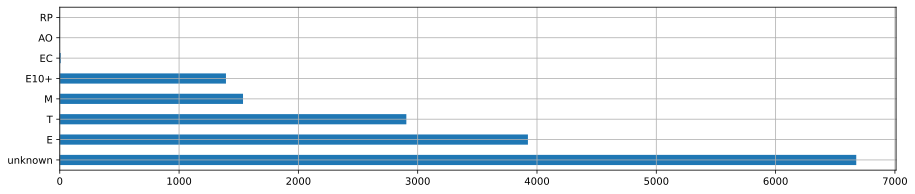

In [18]:
# оценим результат замены
df['rating'].value_counts().plot(kind='barh', grid=True, figsize=(15,3));

In [19]:
# проверим результат
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating                0
dtype: int64

#### 2.3.2 Обработаем пропуски в столбце 'critic_score'

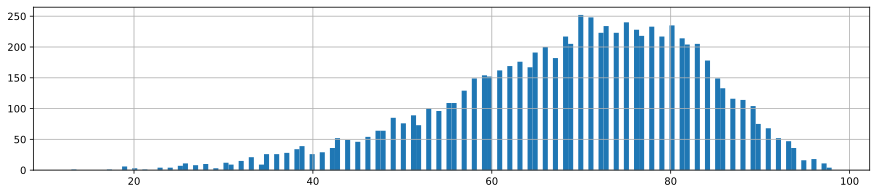

In [20]:
# оценим распределение данных в столбце "critic_score"
df.critic_score.hist(bins=150, grid=True, figsize=(15, 3));

Напоминает нормальное распределение с "левым" хвостом

In [21]:
# сгрупируем оценки критиков по датам релиза
# посмотрим общее количество и медиану
df.groupby('year_of_release').critic_score.agg(['median', 'count'])

,median,count
year_of_release,,
1980,NaN,0
1981,NaN,0
1982,NaN,0
1983,NaN,0
1984,NaN,0
1985,59.0,1
1986,NaN,0
1987,NaN,0
1988,64.0,1


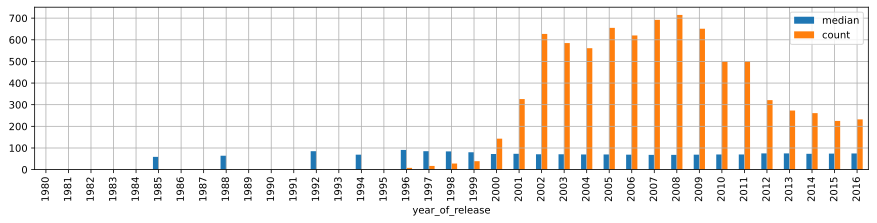

In [22]:
# тоже самое графически
df.groupby('year_of_release').critic_score.agg(['median','count']).plot(kind='bar', grid=True, figsize=(15,3));

По графику видим, что пропуски и отсутствие оценок критиков в основном расположены в годах релизов от 1980 до 1995, можем предположить, что:
1. в период с 1980 - 1995 игр выходило намного меньше в сравнении с периодом 1996 - 2016, поэтому оценок мало
2. игровая индустрия была не настолько развита и не существовал специальный "институт критиков игр"
3. не было системы оценки, поэтому оценок попросту нет

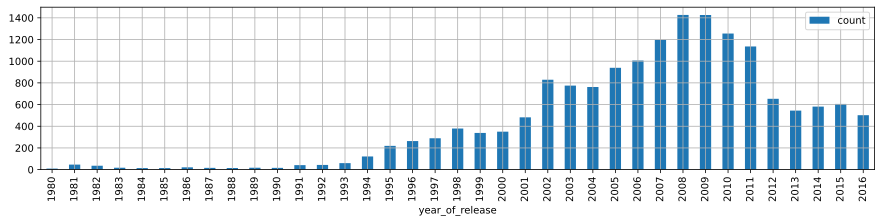

In [23]:
# количество релизов по годам подтверждает идею, мало игр - мало оценок критиков
df.groupby('year_of_release').platform.agg(['count']).plot(kind='bar', grid=True, figsize=(15,3));

##### Вывод:
В столбце 'critic_score' заменить пропуски не можем, пока оставим как есть

#### 2.3.3 Обработаем пропуски в столбце 'user_score'

In [24]:
# посмотрим уникальные значения столбца "user_score"
df['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

Кроме собственнно пропусков - "nan", ещё встречаются значения "tbd".  "TBD" - "To Be Determined", что значит "Будет определено" или "Подлежит уточнению". 

Другими словами - это отсутствие рейтинга в связи с тем, что игра не получила оценок пользователей, поэтому для дальнейшей работы заменим "tbd" на "nan" и приведём столбец типу "float64"

In [25]:
df['user_score'] = df['user_score'].replace('tbd', np.NaN).astype(float)

Оставшиеся в столбце пропуски могут быть связаны с отсутствием данных об оценках пользователей и/или данные были получены в ходе сбора инофрмации для датасета.

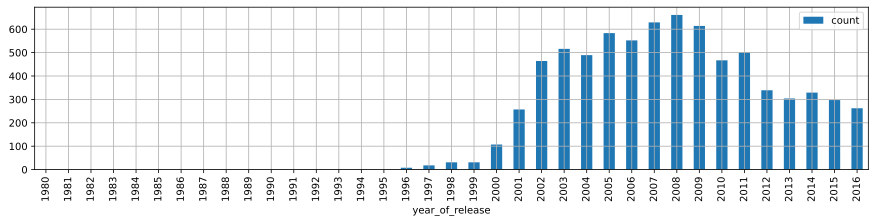

In [26]:
# сгруппируем оценки пользователей по датам релизов
df.groupby('year_of_release').user_score.agg(['count']).plot(kind='bar', grid=True, figsize=(15,3));

График очень напоминает оценки критиков. Оценок пользователей нет для игр выпущенных с 1980 до 1995, можем предположить, что:
1. игры в период с 1980 - 1995 не получили должного внимания и оценок пользователей
2. не было системы оценки, поэтому оценок попросту нет

##### Вывод:
В столбце 'user_score' заменить пропуски не можем, пока оставим как есть

### 2.4 Аббревиатура 'tbd' в столбце с оценкой пользователей 
- разобрали это значение и обработали в п. 2.3.3


In [27]:
# общая информация о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [28]:
# проверим результат
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating                0
dtype: int64

### 2.5 Посчитаем суммарные продажи во всех регионах, запишим их в отдельный столбец

In [29]:
# посчитаем общие продажи и запишем их в столбец 'global_sales' 
df['global_sales'] = df['na_sales']+df['eu_sales']+df['jp_sales']+df['other_sales']

In [30]:
# подсчёт явных дубликатов
df.duplicated().sum()

0

## 3. Исследовательский анализ данных

### 3.1 Cколько игр выпускалось в разные годы
-  важны ли данные за все периоды?

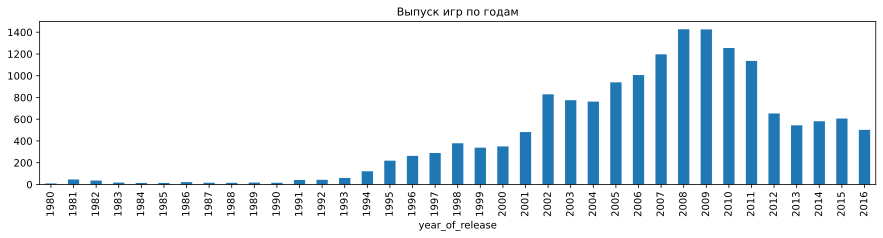

In [31]:
(df.groupby
 ('year_of_release')['name']
 .count()
 .plot(kind='bar', grid=False, figsize=(15,3)
      ).set_title('Выпуск игр по годам', fontsize = 11, color = 'Black')
);

Наибольшее  количество игр было выпущено после 2000 года

In [32]:
# сколько релизов на всех платформах было с 2000 года
df[df['year_of_release'] >= 2000].count()

name               14470
platform           14470
year_of_release    14470
genre              14470
na_sales           14470
eu_sales           14470
jp_sales           14470
other_sales        14470
critic_score        7887
user_score          7371
rating             14470
global_sales       14470
dtype: int64

In [33]:
# сколько релизов на всех платформах было до 2000 года
df[df['year_of_release'] < 2000].count()

name               1974
platform           1974
year_of_release    1974
genre              1974
na_sales           1974
eu_sales           1974
jp_sales           1974
other_sales        1974
critic_score         96
user_score           92
rating             1974
global_sales       1974
dtype: int64

In [34]:
# оставим в выгрузке только нужные года
df = df.query("2000 <= year_of_release")

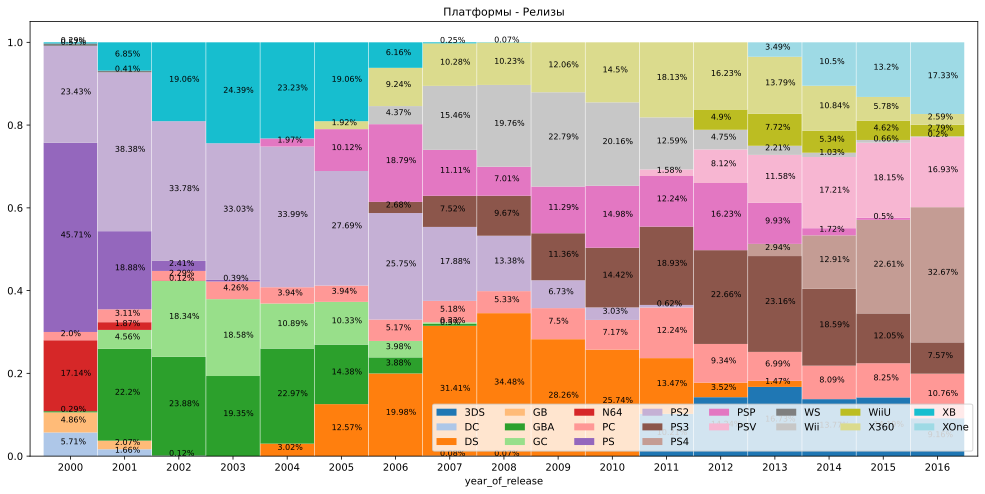

In [35]:
# оценим для каких платформ выпускали игры по годам

df_plat_rel = pd.crosstab(                   # распределение данных внутри столбца по долям
    index = df['year_of_release'], # год релиза из таблицы top_platform
    columns = df['platform'],      # платформы из таблицы top_platform
    values='name',                           # подсчтет по столбцу name
    aggfunc='count',                         # считаем количетсво релизов в столбце name 
    normalize="index"
)

#df_plat_rel = df_plat_rel.replace(0, np.NaN)

df_plat_rel.plot(
    kind='bar',                               # вертикальные столбцы
    width = 0.99,                             # ширина столбца
    figsize=(17,8),                           # размеры фигуры в который размещается диаграмма
    rot=0,                                    # поворот подписей оси Х 
    colormap='tab20',                         # цветовая схема
    stacked=True                              # накопление данных в столбце
).set_title('Платформы - Релизы',             # название диаграммы
            fontsize = 11,                    # размер шрифта
            color = 'Black')                  # цвет шрифта

# подписи долей на графике
for n, x in enumerate([*df_plat_rel.index.values]): # цикл проходит по годам * раскрывает массив как аргументы функции. Пусть a = [6, 7, 8] тогда print(*a) равносильно print(6, 7, 8)
        for (proportion, y_loc) in zip(df_plat_rel.loc[x], df_plat_rel.loc[x].cumsum()): 
            if proportion >0:                                   # печатаем значения только больше 0
                plt.text(x=n - 0.18,                            # положение по оси х
                     y=(y_loc - proportion) + (proportion / 2), # положение по оси у
                     color="black",                             # цвет шрифта подписей
                     s=f'{np.round(proportion*100, 2)}%',       # переводим в проценты и округляем до сотых
                     fontsize=8,                                # размер шрифта подписей
                     #fontweight="bold"                         # шрифт  жирный
                    )
plt.legend(loc="best", ncol=8)                                  # размещение легенды
plt.show()

#### Вывод:
1. Некоторые платформы исчезли после 2000 и новых релизов для них не будет, например: PCFX, GG, NG, SCD и многие другие.
2. Для дальнейшего анализа исключим устаревшие платформы удалив данные до 2000 года.
3. Больше всего игр было выпущено с 2007 по 2008 годы.

### 3.2 Kак менялись продажи по платформам
- как менялись продажи по платформам?
- выберем платформы с наибольшими суммарными продажами и построим распределение по годам
- за какой характерный срок появляются новые и исчезают старые платформы?

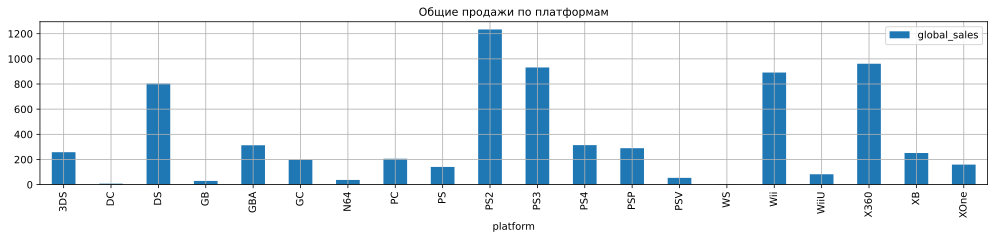

In [36]:
df.pivot_table(
    index = 'platform',
    values = 'global_sales',
    aggfunc='sum').plot(y='global_sales', 
                                       kind='bar', 
                                       grid=True, 
                                       figsize=(17, 3)
).set_title('Общие продажи по платформам', fontsize = 11, color = 'Black');

In [37]:
# 15 платформ с наибольшими продажами в мире
top = (
    df.groupby(['platform'])['global_sales']
    .sum()
    .sort_values(ascending = False)
    .head(15)
    .to_frame()
    .reset_index()
)
top.style.bar()

,platform,global_sales
0,PS2,1233.560000
1,X360,961.240000
2,PS3,931.340000
3,Wii,891.180000
4,DS,802.760000
5,PS4,314.140000
6,GBA,312.880000
7,PSP,289.530000
8,3DS,257.810000
9,XB,251.570000


In [38]:
# соберем отдельный датасет из ТОП-15 платформ
top_platform = df[df['platform'].isin(top['platform'])]
top_platform

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
0,Wii Sports,Wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
...,...,...,...,...,...,...,...,...,...,...,...,...
16437,Woody Woodpecker in Crazy Castle 5,GBA,2002,platform,0.01,0.00,0.00,0.00,NaN,NaN,unknown,0.01
16438,SCORE International Baja 1000: The Official Game,PS2,2008,racing,0.00,0.00,0.00,0.00,NaN,NaN,unknown,0.00
16439,Samurai Warriors: Sanada Maru,PS3,2016,action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16440,LMA Manager 2007,X360,2006,sports,0.00,0.01,0.00,0.00,NaN,NaN,unknown,0.01


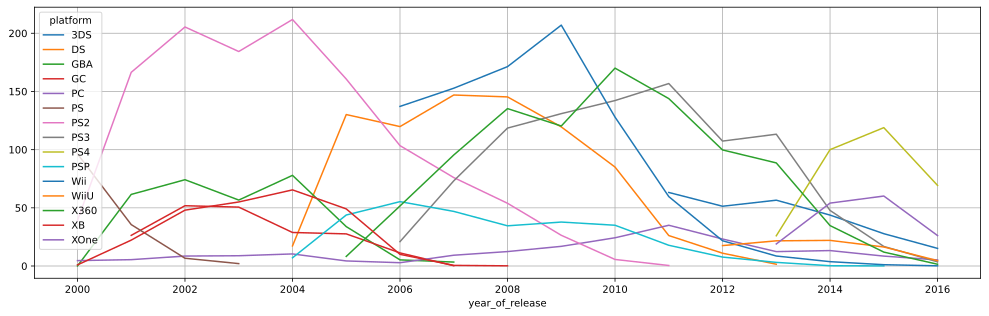

In [39]:
# динамика общих продаж по ТОП платформам
(top_platform.pivot_table(
    index='year_of_release', 
    columns = 'platform', 
    values='global_sales', 
    aggfunc='sum')
 .plot(grid=True, figsize=(17, 5))
)
plt.show()

1. На графиках видны "взлеты" и падения продаж у платформ с течением времени
2. Большинство платформ на "закате", например: PS2, DS, GC
4. Продажи практически по всем платформам снизились в 2013-2014 гг
3. PS4 и XOne выделяются своей положительной динамикой по продажам (снижение 2016 году вероятно связанно с тем, что данные по продажам не за полный год)

In [40]:
# посчитаем сколько лет выпускались игры для каждой из ТОП платформ
year = (top_platform.loc[:,['platform', 'year_of_release']]
             .drop_duplicates()
             .pivot_table(
                 index=['platform'], 
                 values='year_of_release',
                 aggfunc='count')
            ).sort_values(
    by= 'year_of_release')
year

,year_of_release
platform,
PS,4
PS4,4
XOne,4
WiiU,5
3DS,6
GC,7
GBA,8
XB,9
DS,10


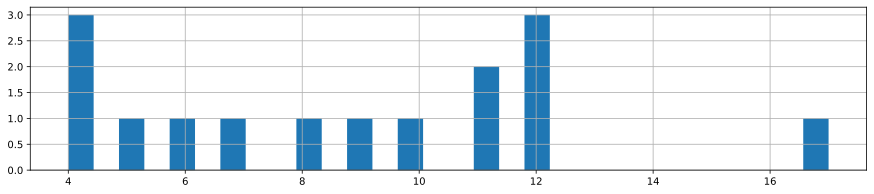

In [41]:
# посмотрим как распределяются данные на гистограмме
year.year_of_release.hist(bins=30, grid=True, figsize=(15, 3));

1. Есть платформы "долгожители" - PC, но это скорее исключение из правил

In [42]:
# удалим платформы для которых игры выпускались более 12 лет
year = year.query('year_of_release <= 12')

In [43]:
# оценим среднюю продолжительность жизни ТОП платформ 
year.year_of_release.describe()

count    14.000000
mean      8.214286
std       3.190818
min       4.000000
25%       5.250000
50%       8.500000
75%      11.000000
max      12.000000
Name: year_of_release, dtype: float64

##### Вывод:
1. Средний срок поддержки наиболее рейтинговых по глобальным продажам платформ около 8 лет.
2. В течении этого времени для ТОП-15 платформ выпускаются новые игры и они приносят прибыль.
3. Можно предположить, что для дальнейшего анализа необходимо оставить платформы, возраст которых на момент 2016 года не более 4 лет.
4. Вероятно, что для этих платформ игры будут выпускать в течении ближайших 4 лет.
5. Таким образом оставим актуальный временной период 2013 - 2016 гг.

### 3.3 Возьмем данные за 2013 - 2016 год
- определим лидеров по продажам и посмотрим динамику 
- выберем несколько потенциально прибыльных платформ
- построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам

In [44]:
# оставим в выгрузке только нужные года
df_sample = df.query("2012 < year_of_release")
df_sample.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
16,Grand Theft Auto V,PS3,2013,action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,role-playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,14.60
42,Grand Theft Auto V,PS4,2014,action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,role-playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,11.68
60,Call of Duty: Ghosts,X360,2013,shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24
69,Call of Duty: Ghosts,PS3,2013,shooter,4.10,3.63,0.38,1.25,71.0,2.6,M,9.36
72,Minecraft,X360,2013,misc,5.70,2.65,0.02,0.81,NaN,NaN,unknown,9.18
77,FIFA 16,PS4,2015,sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58


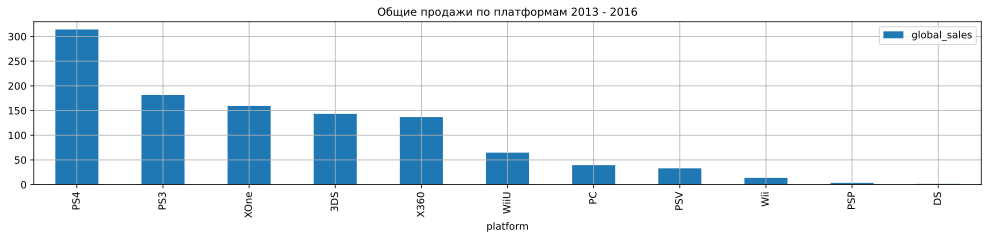

In [45]:
# оценим общие продажи за период 2013 - 2016
df_sample.pivot_table(
    index = 'platform',
    values = 'global_sales',
    aggfunc='sum').sort_values(
    by= 'global_sales', ascending = False).plot(
    y='global_sales', 
    kind='bar', 
    grid=True, 
    figsize=(17, 3)
).set_title('Общие продажи по платформам 2013 - 2016', fontsize = 11, color = 'Black');

In [46]:
# оценим продажи по платформам в регионах и общие за период 2012 - 2016
df_sample_top_sales = (
    df_sample.groupby(['platform'])
    [['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'global_sales']]
    .sum()
    .sort_values(by = 'global_sales', ascending = False)
)
df_sample_top_sales

,na_sales,eu_sales,jp_sales,other_sales,global_sales
platform,,,,,
PS4,108.74,141.09,15.96,48.35,314.14
PS3,63.50,67.81,23.35,26.77,181.43
XOne,93.12,51.59,0.34,14.27,159.32
3DS,38.20,30.96,67.81,6.28,143.25
X360,81.66,42.52,0.51,12.11,136.80
WiiU,29.21,19.85,10.88,4.69,64.63
PC,11.11,25.36,0.00,2.96,39.43
PSV,5.04,6.10,18.59,3.26,32.99
Wii,6.56,5.93,0.05,1.12,13.66


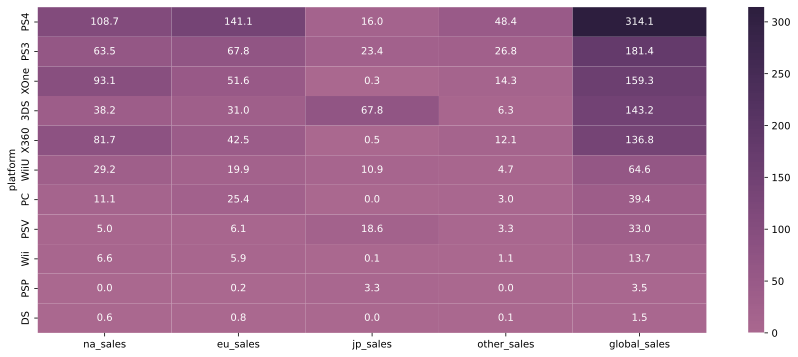

In [47]:
# хитмэп продаж по платформам в регионах и общие за период 2013 - 2016
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(df_sample_top_sales, annot=True, fmt=".1f", center = True, cmap=sns.cubehelix_palette(as_cmap=True));

In [48]:
# платформы - лидеры продаж в мире за 2013-2016
top_platform = (
    df_sample.groupby(['platform'])['global_sales']
    .sum()
    .sort_values(ascending = False)
    .head(5)
    .to_frame().reset_index() 
)

top_platform

,platform,global_sales
0,PS4,314.14
1,PS3,181.43
2,XOne,159.32
3,3DS,143.25
4,X360,136.80


### 3.4 Динамика продаж по ТОП-5 платформ

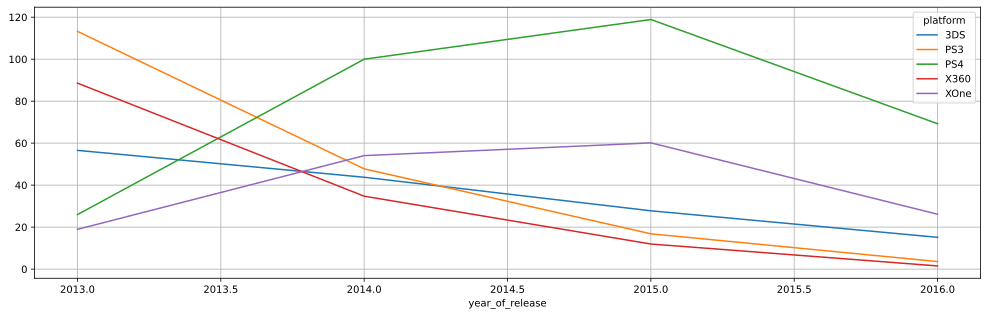

In [49]:
# посмотрим на динамику продаж по годам платформ из top_platform
top_sales_platform = df_sample[df_sample['platform'].isin(top_platform['platform'])]

(top_sales_platform.pivot_table(
    index='year_of_release', 
    columns = 'platform', 
    values='global_sales', 
    aggfunc='sum')
 .plot(grid=True, figsize=(17, 5))
)
plt.show()

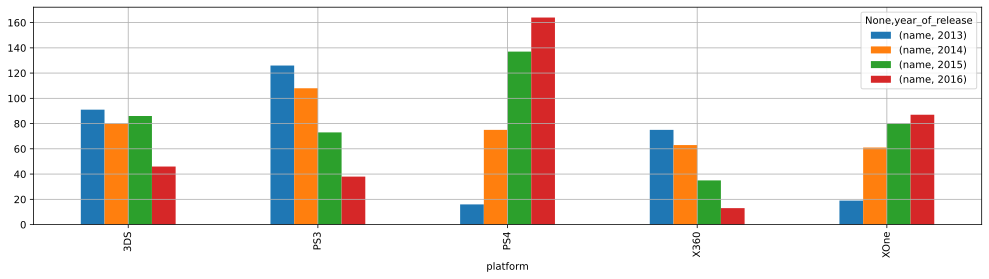

In [50]:
# посчитаем динамику релизов для ТОП-5 платформ за период 2013 - 2016

(top_sales_platform[(top_sales_platform['platform'].isin(top_platform['platform']))]
 .pivot_table('name',['platform','year_of_release'], aggfunc='count')
 .unstack()
 .plot(kind='bar', grid=True, figsize = (17, 4))
);

1. Количество игр выпускаемых для 3DS, PS3 и X360 - уменьшилось с 2013 по 2016
2. Количество релизов для PS4 и XOne - увеличивалось

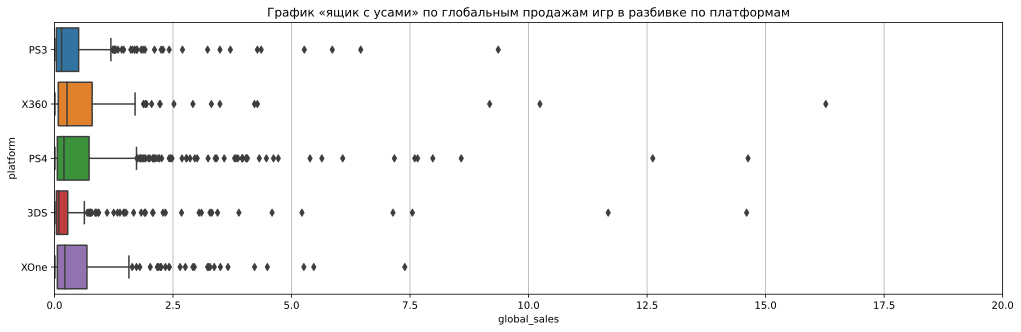

In [51]:
# построим графики "ящик с усами"
modern_platform = top_sales_platform.platform.value_counts().sort_values(ascending = False).head(5).index.values

fig, ax = plt.subplots(figsize = (17,5))
# удалим редкие выбросы по платформам ограничив верхнюю границу диаграммы на 6 млн.
ax.set_xlim(0, 20)
ax.grid(True)
ax.set_title('График «ящик с усами» по глобальным продажам игр в разбивке по платформам')
sns.boxplot(y="platform", x="global_sales", data=top_sales_platform[top_sales_platform.platform.isin(modern_platform)]);

1. Выбросы в продажах есть на всех платформах, на некоторых они значительные, что говорит о наличии культовых игр с выдающимися продажами.
2. Медианы PS3 и PS4 совпадают, что может говорить об одинаковом распределении продаж или о преемственности платформ.

In [52]:
# сравним значения описательных статистик по платформам для столбца "global_sales" 
func_describe = {'global_sales': ['describe']}
top_sales_platform.groupby(['platform']).agg(func_describe).round(2)

global_sales                                           
             describe                                           
                count  mean   std   min   25%   50%   75%    max
platform                                                        
3DS             303.0  0.47  1.38  0.01  0.04  0.09  0.28  14.60
PS3             345.0  0.53  1.45  0.01  0.04  0.15  0.51  21.05
PS4             392.0  0.80  1.61  0.01  0.06  0.20  0.73  14.63
X360            186.0  0.74  1.66  0.01  0.08  0.26  0.80  16.27
XOne            247.0  0.65  1.04  0.01  0.06  0.22  0.68   7.39

In [53]:
# в общих продажах по платформам посчитаем сумму общих продаж
# среднее значение, медиану, минимальные и максимальные продажи
func = {'global_sales': ['sum', 'mean', 'median', 'min', 'max']}
top_sales_platform.groupby(['platform']).agg(func).round(2)

global_sales                          
                  sum  mean median   min    max
platform                                       
3DS            143.25  0.47   0.09  0.01  14.60
PS3            181.43  0.53   0.15  0.01  21.05
PS4            314.14  0.80   0.20  0.01  14.63
X360           136.80  0.74   0.26  0.01  16.27
XOne           159.32  0.65   0.22  0.01   7.39

##### Вывод:
1. С выходом в 2013 году PS4 и XOne продажи игр для других платформ снижаются.
2. Количество новых релизов снижается для всех платформ, кроме PS4 и XOne.
3. Платформы PS3 и X360, которые занимали лидирующие позиции по продажам игр в 2010-2012 гг., в настоящее показывают снижение продаж, вероятно из-за отсутствия новых игр и перехода игроков на современные платформы, пришедшие им на замену.
4. Похоже, что PS4 и XOne остануться лидерами и в 2017 г, если не появится новая платформа.
5. Для дальнейшего анализа оставим продажи для платформ PS4, XOne за период  2013-2016 гг. 

In [54]:
# оставим в выгрузке только две платформы
df_sample_two = df.query("platform == ['XOne', 'PS4']")

df_sample_two.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
31,Call of Duty: Black Ops 3,PS4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
42,Grand Theft Auto V,PS4,2014,action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015,sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.98
92,Call of Duty: Advanced Warfare,PS4,2014,shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
94,FIFA 17,PS4,2016,sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
99,Call of Duty: Black Ops 3,XOne,2015,shooter,4.59,2.11,0.01,0.68,NaN,NaN,unknown,7.39
105,Fallout 4,PS4,2015,role-playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17
143,FIFA 15,PS4,2014,sports,0.80,4.33,0.05,0.90,82.0,5.7,E,6.08
154,Destiny,PS4,2014,shooter,2.49,2.07,0.16,0.92,76.0,6.1,T,5.64


### 3.5 Влияние отзывов пользователей и критиков на продажи внутри одной популярной платформы
- по сумме продаж за период 2013-2016 лидирует PS4
- рассмотрим корреляцию отзывов и продаж на примере этой платформы

Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

##### Диаграмма рассеяния: общие продажи - оценки критиков

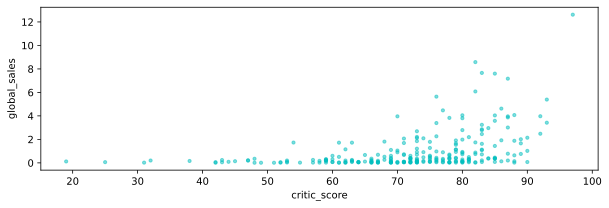

In [55]:
df_sample_two[df_sample_two['platform']=='PS4'].plot(kind='scatter', x='critic_score', y='global_sales', alpha=0.5, subplots=True, figsize=(10,3), c = 'c', s = 10);

In [56]:
df_ps4 = df_sample_two[df_sample_two['platform']=='PS4']
df_ps4

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
31,Call of Duty: Black Ops 3,PS4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
42,Grand Theft Auto V,PS4,2014,action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015,sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.98
92,Call of Duty: Advanced Warfare,PS4,2014,shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
...,...,...,...,...,...,...,...,...,...,...,...,...
16230,Root Letter,PS4,2016,adventure,0.00,0.00,0.01,0.00,69.0,7.5,unknown,0.01
16233,Shin Hayarigami 2,PS4,2016,adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16255,Dungeons 2,PS4,2016,role-playing,0.01,0.00,0.00,0.00,61.0,7.9,T,0.01
16259,Carmageddon: Max Damage,PS4,2016,action,0.01,0.00,0.00,0.00,51.0,5.5,M,0.01


In [57]:
df_ps4[['critic_score', 'global_sales']].corr()

,critic_score,global_sales
critic_score,1.000000,0.406568
global_sales,0.406568,1.000000


Для платформы PS4 корреляция продаж и оценки критиков: 0,40 - средняя зависимость, положительная.

#### Гипотеза:
- H0: оценки критиков не влияют на уровень продаж игр
- H1: есть зависимость между оценками критиков и уровнем продаж игр

In [58]:
# остались строки с пропусками в столбцах 'critic_score' и 'user_score'
df_ps4.isna().sum()

name                 0
platform             0
year_of_release      0
genre                0
na_sales             0
eu_sales             0
jp_sales             0
other_sales          0
critic_score       140
user_score         135
rating               0
global_sales         0
dtype: int64

In [59]:
# прежде, чем проводить тест - удалим строки с пропусками, сборосим и перезапишем индексы
df_ps4 = df_ps4.dropna(subset=['critic_score','user_score']).reset_index(drop=True)

In [60]:
# проведем статистический тест, чтобы подвтердить или опровергнуть гипотезу
stat, p = st.stats.pearsonr(df_ps4.critic_score, df_ps4.global_sales)
print(f'stat={stat:.3f}, p={p:.3f}')
if p > 0.05:
    print('Нет достаточных оснований, чтобы отклонить H0')
else:
    print('Есть достаточно оснований, чтобы отклонить H0, принимаем H1.')

stat=0.406, p=0.000
Есть достаточно оснований, чтобы отклонить H0, принимаем H1.


##### Диаграмма рассеяния: общие продажи - оценки пользователей

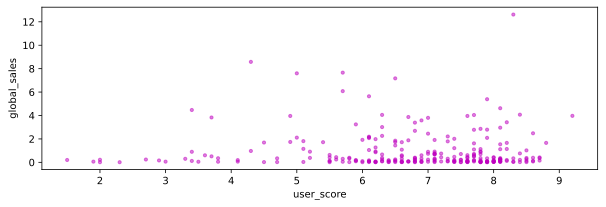

In [61]:
df_sample_two[df_sample_two['platform']=='PS4'].plot(kind='scatter', x='user_score', y='global_sales', alpha=0.5, subplots=True, figsize=(10,3), c = 'm', s = 10);

In [62]:
df_ps4[['user_score', 'global_sales']].corr()

,user_score,global_sales
user_score,1.000000,-0.033625
global_sales,-0.033625,1.000000


Для платформы PS4 корреляция между оценками пользователей и общими продажами: -0,034 - слабая, отрицательная.

#### Гипотеза:
- H0: оценки пользователей не влияют на уровень продаж игр
- H1: есть зависимость между оценками критиков и уровнем продаж игр

In [63]:
# проведем статистический тест, чтобы подвтердить или опровергнуть гипотезу
stat, p = st.stats.pearsonr(df_ps4.user_score, df_ps4.global_sales)
print(f'stat={stat:.3f}, p={p:.3f}')
if p > 0.05:
    print('Нет достаточных оснований, чтобы отклонить H0')
else:
    print('Есть достаточно оснований, чтобы отклонить H0, принимаем H1.')

stat=-0.034, p=0.597
Нет достаточных оснований, чтобы отклонить H0


##### Вывод:
1. Есть достаточно оснований для предположения влияния оценки критиков на уровень продаж игр для  PS4
2. Нет достаточных оснований влияний оценки пользователей на уровень продаж игр для PS4

### 3.6 Соотнесём выводы корреляции с продажами игр на других платформах

In [64]:
# оценку проведем на отобранных ранее ТОП-5 платформ по продажам за период 2013-2016
top_sales_platform

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
16,Grand Theft Auto V,PS3,2013,action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,role-playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,14.60
42,Grand Theft Auto V,PS4,2014,action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16401,Metal Gear Solid V: The Definitive Experience,XOne,2016,action,0.01,0.00,0.00,0.00,NaN,NaN,M,0.01
16403,Tsukigime Ranko's Longest Day,PS3,2014,action,0.00,0.01,0.00,0.00,NaN,NaN,unknown,0.01
16406,Aikatsu Stars! My Special Appeal,3DS,2016,action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16420,Dynasty Warriors: Eiketsuden,PS3,2016,action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01


In [65]:
# оценим корреляцию продаж и оценок критиков у ТОП-5 платформ
top_sales_platform[['critic_score', 'global_sales']].corr()

,critic_score,global_sales
critic_score,1.000000,0.360374
global_sales,0.360374,1.000000


Корреляция продаж и оценки критиков для ТОП-5 платформ: 0,35 - средняя зависимость, положительная.

#### Гипотеза:
- H0: оценки критиков не влияют на уровень продаж игр
- H1: есть зависимость между оценками критиков и уровнем продаж игр

In [66]:
# проведем очистку от пропусков в 'critic_score' и 'user_score'
# прежде, чем проводить тест - удалим строки с пропусками, сборосим и перезапишем индексы
top_sales_platform = top_sales_platform.dropna(subset=['critic_score','user_score']).reset_index(drop=True)

In [67]:
# проведем статистический тест, чтобы подвтердить или опровергнуть гипотезу
stat, p = st.stats.pearsonr(top_sales_platform.critic_score, top_sales_platform.global_sales)
print(f'stat={stat:.3f}, p={p:.3f}')
if p > 0.05:
    print('Нет достаточных оснований, чтобы отклонить H0')
else:
    print('Есть достаточно оснований, чтобы отклонить H0, принимаем H1.')

stat=0.358, p=0.000
Есть достаточно оснований, чтобы отклонить H0, принимаем H1.


In [68]:
# оценим корреляцию продаж и оценок пользователей у ТОП-5 платформ
top_sales_platform[['user_score', 'global_sales']].corr()

,user_score,global_sales
user_score,1.000000,-0.013332
global_sales,-0.013332,1.000000


Корреляция между оценками пользователей и общими продажами ТОП-5 платформ: 0,001 - очень слабая, положительная.

#### Гипотеза:
- H0: оценки пользователей не влияют на уровень продаж игр
- H1: есть зависимость между оценками критиков и уровнем продаж игр

In [69]:
# проведем статистический тест, чтобы подвтердить или опровергнуть гипотезу
stat, p = st.stats.pearsonr(top_sales_platform.user_score, top_sales_platform.global_sales)
print(f'stat={stat:.3f}, p={p:.3f}')
if p > 0.05:
    print('Нет достаточных оснований, чтобы отклонить H0')
else:
    print('Есть достаточно оснований, чтобы отклонить H0, принимаем H1.')

stat=-0.013, p=0.728
Нет достаточных оснований, чтобы отклонить H0


#### Вывод:
1. Полученные результаты для ТОП-5 платформ о влиянии отзывов пользователей и критиков на продажи совпадают с ранее полученными для PS4
2. Есть достаточно оснований для предположения оценки критиков оказывают влияние на уровень продаж игр.
3. Нет достаточных оснований для предположения о влияний оценок пользователей на уровень продаж игр.

### 3.7 Общее распределение игр по жанрам
- самые прибыльные жанры 
- жанры с низкими продажами

In [70]:
# df_sample

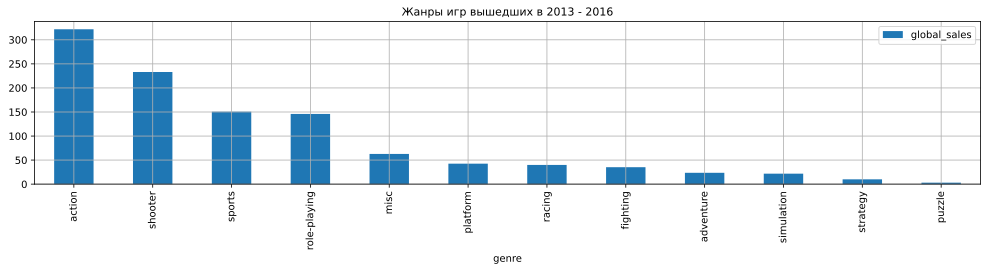

In [71]:
df_sample.pivot_table(
    index = 'genre',
    values = 'global_sales',
    aggfunc='sum').sort_values(
    by= 'global_sales', ascending = False).plot(
    y='global_sales', 
    kind='bar', 
    grid=True, 
    figsize=(17, 3)
).set_title('Жанры игр вышедших в 2013 - 2016', fontsize = 11, color = 'Black');

In [72]:
# ТОП - 5 самых продаваемых жанра игр за период с 2013-2016
best_sales_genre = df_sample.pivot_table(
    index = 'genre',
    values = 'global_sales',
    aggfunc=['median','mean','sum'])

# удалим мультииндекс (стороку 1)
best_sales_genre.columns = best_sales_genre.columns.droplevel(1)

# найдем 5 лучших по медиане, т.к. среднее не информативна, если есть очень большие и очень низкие показатели
(best_sales_genre
 .sort_values(by= ['median'], ascending = False)
 .head(5)
 .reset_index()
 .style
 .bar('median')
)

,genre,median,mean,sum
0,shooter,0.450000,1.245882,232.980000
1,sports,0.240000,0.703972,150.650000
2,platform,0.225000,0.576081,42.630000
3,role-playing,0.125000,0.499623,145.890000
4,fighting,0.125000,0.441375,35.310000


In [73]:
# ТОП - 5 плохо продающихся жанров игр за период с 2013-2016
bad_sales_genre = df_sample.pivot_table(
    index = 'genre',
    values = 'global_sales',
    aggfunc=['median','mean','sum'])

# удалим мультииндекс (стороку 1)
bad_sales_genre.columns = bad_sales_genre.columns.droplevel(1)

# найдем 5 худших по медиане, т.к. среднее не информативна, если есть очень большие и очень низкие показатели
(bad_sales_genre
 .sort_values(by= ['median'], ascending = False)
 .tail(5)
 .reset_index()
 .style
 .bar('median')
)

,genre,median,mean,sum
0,simulation,0.100000,0.350968,21.760000
1,misc,0.100000,0.405290,62.820000
2,strategy,0.080000,0.180000,10.080000
3,puzzle,0.060000,0.186471,3.170000
4,adventure,0.030000,0.096490,23.640000


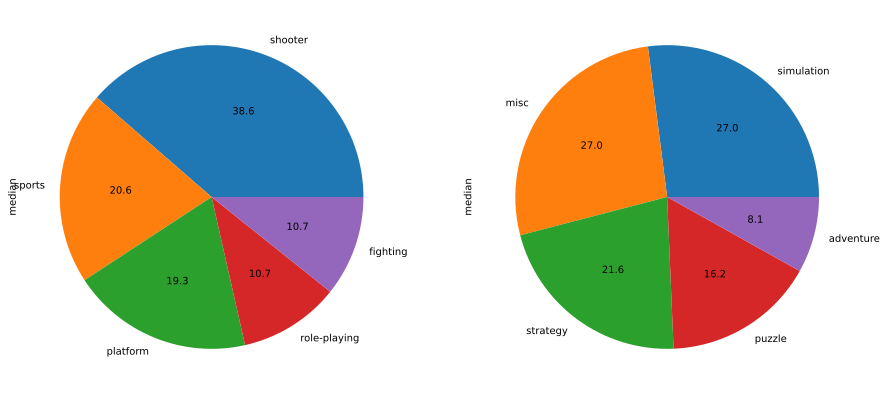

In [74]:
# доли продаж лучших и худших жанров по медиане
fig, axis = plt.subplots(1,2, figsize=(15,8))

(best_sales_genre['median']
 .sort_values(ascending = False)
 .head(5)
 .plot
 .pie(autopct='%.1f', ax=axis[0], subplots=True)
);

(bad_sales_genre['median']
 .sort_values(ascending = False)
 .tail(5)
 .plot
 .pie(autopct='%.1f', ax=axis[1], subplots=True)
);

#### Вывод:
1. Всего за период 2013 - 2016 выходили игр в 12 жанрах
2. ТОП-5 жанров с лучшими продажами за период 2013 - 2016 в порядке убывания: shooter, sports, platfom, role-playing, fighting  
3. ТОП-5 жанром с худшими продажами за период 2013 - 2016 в порядке возрастания: simulation, misc, strategy, puzzle, strategy, adventure

## 4. Портрет пользователя каждого региона

### 4.1 Пользователь каждого региона (NA, EU, JP)
- ТОП-5 популярных платформ
- ТОП-5 популярных жанров

In [75]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
0,Wii Sports,Wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


#### 4.1.1 ТОП-5 платформ в регионах

In [76]:
# оценим продажи по платформам в регионах 2016
df_top_platform = (
    df_sample.groupby(['platform'])
    [['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'global_sales']]
    .sum()
    .sort_values(by = 'global_sales', ascending = False)
)
df_top_platform.reset_index().head(5)

,platform,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,PS4,108.74,141.09,15.96,48.35,314.14
1,PS3,63.50,67.81,23.35,26.77,181.43
2,XOne,93.12,51.59,0.34,14.27,159.32
3,3DS,38.20,30.96,67.81,6.28,143.25
4,X360,81.66,42.52,0.51,12.11,136.80


#### 4.1.2 Доли продаж регионов для популярных платформ

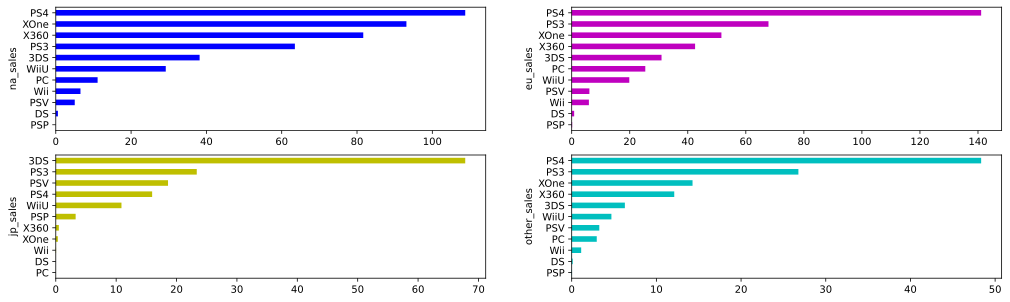

In [77]:
# отобразим данные на графике
fig, axis = plt.subplots(2,2, figsize=(17,5))

df_top_platform['na_sales'].sort_values(ascending=True).plot.barh(ax=axis[0,0], color = 'b').set(ylabel='na_sales');
df_top_platform['eu_sales'].sort_values(ascending=True).plot.barh(ax=axis[0,1], color = 'm').set(ylabel='eu_sales');
df_top_platform['jp_sales'].sort_values(ascending=True).plot.barh(ax=axis[1,0], color = 'y').set(ylabel='jp_sales');
df_top_platform['other_sales'].sort_values(ascending=True).plot.barh(ax=axis[1,1], color = 'c').set(ylabel='other_sales');

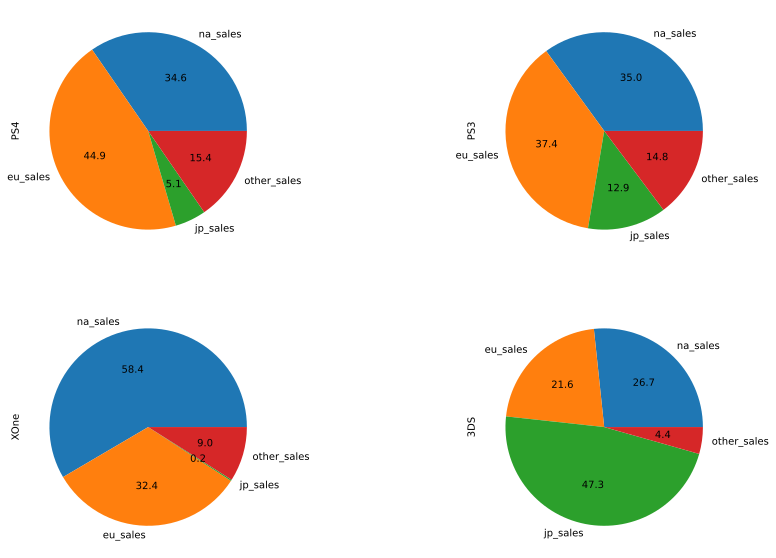

In [78]:
# доли регионов в продажах игр популярных платформ
fig, axis = plt.subplots(2,2, figsize=(15,10))

df_top_platform.loc['PS4',['na_sales','eu_sales','jp_sales','other_sales']].plot.pie(autopct='%.1f',ax=axis[0,0]);
df_top_platform.loc['PS3',['na_sales','eu_sales','jp_sales','other_sales']].plot.pie(autopct='%.1f',ax=axis[0,1]);
df_top_platform.loc['XOne',['na_sales','eu_sales','jp_sales','other_sales']].plot.pie(autopct='%.1f',ax=axis[1,0]);
df_top_platform.loc['3DS',['na_sales','eu_sales','jp_sales','other_sales']].plot.pie(autopct='%.1f',ax=axis[1,1]);

#### 4.1.3 ТОП-5 жанров по регионам продаж

In [79]:
# оценим продажи по жанрам в регионах 2016
df_top_genre = (
    df_sample.groupby(['genre'])
    [['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'global_sales']]
    .sum()
    .sort_values(by = 'global_sales', ascending = False)
)
df_top_genre.reset_index().head(5)

,genre,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,action,126.05,118.13,40.49,37.20,321.87
1,shooter,109.74,87.86,6.61,28.77,232.98
2,sports,65.27,60.52,5.41,19.45,150.65
3,role-playing,46.40,36.97,51.04,11.48,145.89
4,misc,27.49,20.04,9.20,6.09,62.82


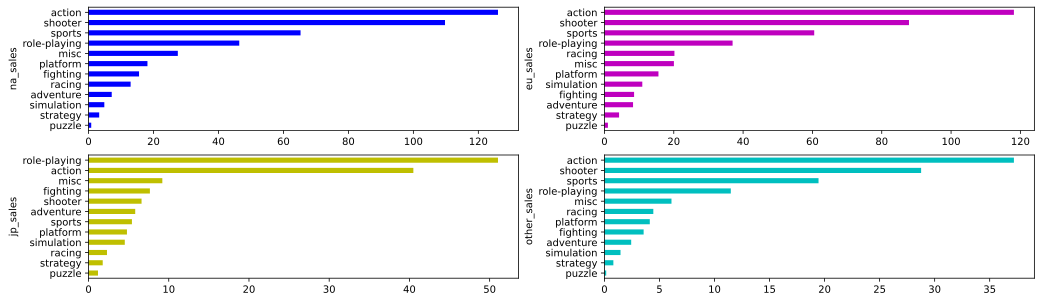

In [80]:
# отбразим данные на графике
fig, axis = plt.subplots(2,2, figsize=(17,5))

df_top_genre['na_sales'].sort_values(ascending=True).plot.barh(ax=axis[0,0], color = 'b').set(ylabel='na_sales');
df_top_genre['eu_sales'].sort_values(ascending=True).plot.barh(ax=axis[0,1], color = 'm').set(ylabel='eu_sales');
df_top_genre['jp_sales'].sort_values(ascending=True).plot.barh(ax=axis[1,0], color = 'y').set(ylabel='jp_sales');
df_top_genre['other_sales'].sort_values(ascending=True).plot.barh(ax=axis[1,1], color = 'c').set(ylabel='other_sales');

#### 4.1.4 Доли продаж регионов в популярных жанрах

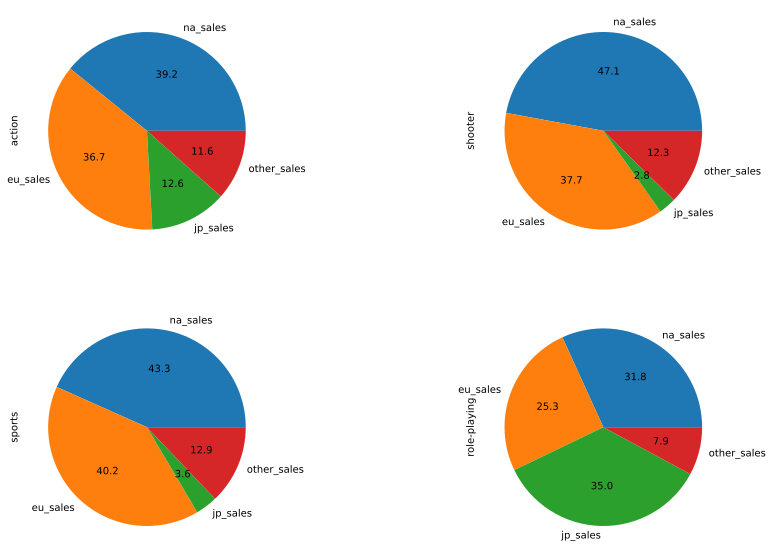

In [81]:
# доли регионов в продажах игр для самых популярных жанров
fig, axis = plt.subplots(2,2, figsize=(15,10))

df_top_genre.loc['action',['na_sales','eu_sales','jp_sales','other_sales']].plot.pie(autopct='%.1f', ax=axis[0,0]);
df_top_genre.loc['shooter',['na_sales','eu_sales','jp_sales','other_sales']].plot.pie(autopct='%.1f', ax=axis[0,1]);
df_top_genre.loc['sports',['na_sales','eu_sales','jp_sales','other_sales']].plot.pie(autopct='%.1f', ax=axis[1,0]);
df_top_genre.loc['role-playing',['na_sales','eu_sales','jp_sales','other_sales']].plot.pie(autopct='%.1f', ax=axis[1,1]);

#### Вывод
**ТОП-5 платформ**
1. Северная Америка: PS4, XOne, X360, PS3, 3DS
2. Европа: PS4, PS3, XOne, X360, 3DS 
3. Япония: 3DS, PS3, PSV, PS4, WiiU


**ТОП-5 жанров**
1. Северная Америка: action, shooter, sports, role-playing, misc 
2. Европа: action, shooter, sports, role-playing, racing 
3. Япония: role-playing, action, misc, fighting, shooter

* для региона Северная Америка заметна борьба за пользователя "местного" производителя с "импортным" (Sony vs. Microsoft)
* предпочтения в жанрах явно связаны с предпочтениями к определенным платформам - мощные платформы заточены под экшен и шутеры
* в Японии своя атмосфера - ролевые, файтинг и Nintendo в топе - особенности культуры

### 4.2 Влияние рейтинга ESRB на продажи в отдельном регионе

In [82]:
# рассмотрим данные только за последний год
# df_2016

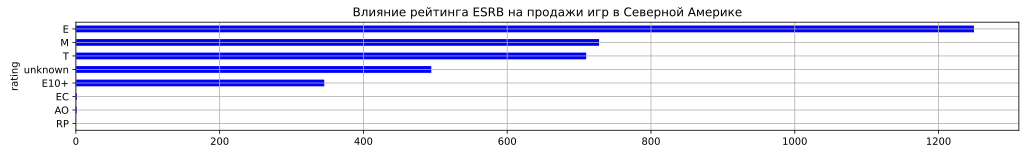

In [83]:
# оценим влияние рейтинга ESRB на продажи игр в Северной Америке
na_rating = (
    df.groupby('rating')['na_sales']
    .sum()
    .sort_values()
    .plot(y='rating',
          x='na_sales', 
          kind='barh', 
          figsize=(17,2), 
          grid=True, 
          color='b', 
          title='Влияние рейтинга ESRB на продажи игр в Северной Америке')
)

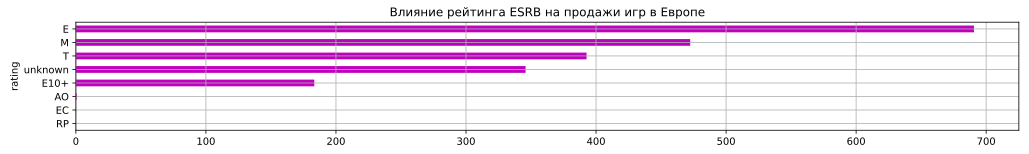

In [84]:
# оценим влияние рейтинга ESRB на продажи игр в Европе
na_rating = (
    df.groupby('rating')['eu_sales']
    .sum()
    .sort_values()
    .plot(y='rating', 
          x='eu_sales', 
          kind='barh', 
          figsize=(17,2), 
          grid=True, 
          color='m', 
          title='Влияние рейтинга ESRB на продажи игр в Европе')
)

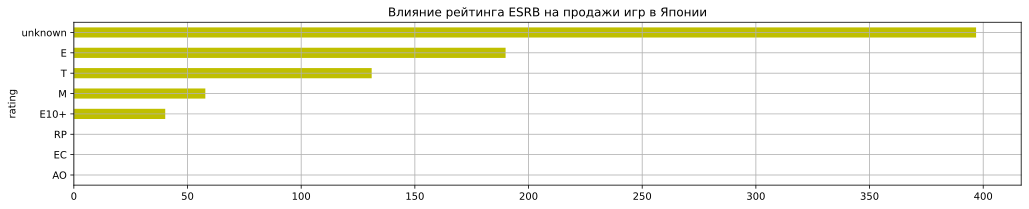

In [85]:
# оценим влияние рейтинга ESRB на продажи игр в Японии
na_rating = (
    df.groupby('rating')['jp_sales']
    .sum()
    .sort_values()
    .plot(y='rating', 
          x='jp_sales', 
          kind ='barh', 
          figsize=(17,3), 
          grid=True,
          color='y',
          title='Влияние рейтинга ESRB на продажи игр в Японии')
)

#### Вывод:
1. Перове место по продажм в в Северной Америке и Европе игры с рейтингом "Е" - для всех возрастных категорий. Игра не должна содержать звуков или изображений, которые могут напугать маленьких детей. Не должна использоваться ненормативная лексика. Примеры: Просто таннцуй, FIFA.  
2. На втором месте по продажам в Северной Америке и Европе игры с рейтингом "М" - для лиц старше 17 лет. Этот рейтинг используется, когда насилие становится реалистичным и похожим на реальную жизнь. Также может присутствовать ненормативная лексика, употребление табака, алкоголя или запрещенных наркотиков. Примеры: Ark: Survival Evolved, Destiny 2.
3. На третьем месте по продажам в Америке и Европе игры с рейтингом "Т" - для лиц старше 13 лет. Игра может содержать более реалистичные и натуралистические сцены насилия. Примеры: Fortnite, Sims 4
4. В Японии лучше всего продаются игры, которые наше датасете имеют рейтинг "unknown" - "неизвестен". Вероятно, это связано с наличием собственной ситемы рейтинга. 

## 5. Проверим гипотезы

In [86]:
# рассмотрим данные только за последний год
df_2016 = df.query('year_of_release == 2016')

In [87]:
# удалим пропущенные значения в 'user_score', удалим строки с пропусками, сборосим и перезапишем индексы 
df_2016 = df_2016.dropna(subset=['user_score']).reset_index(drop=True)

### 5.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

#### Гипотеза:
- H0: средний пользовательский рейтинг платформы Xbox One = среднему пользовательскому рейтингу платформы PC
- H1: средний пользовательский рейтинг платформы Xbox One ≠ среднему пользовательскому рейтингу платформы PC
- критический уровень статистической значимости alpha = 0.05

In [88]:
# соберем данные о рейтинге платформы Xbox в отдельный список
xbox = list(df_2016[(df_2016['platform'] == 'XOne')]['user_score'])

In [89]:
# соберем данные о рейтинге платформы PC в отдельный список
pc = list(df_2016[(df_2016['platform'] == 'PC')]['user_score'])

In [90]:
alpha = 0.05 # критический уровень статистической значимости

# вызов метода для проверки гипотезы
results = st.ttest_ind(
    xbox,
    pc,
equal_var = False)
print('p-значение: {:.2f}'.format(results.pvalue))

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.35
Не получилось отвергнуть нулевую гипотезу


#### Вывод:
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

### 5.2 Средние пользовательские рейтинги жанров Action и Sports разные

#### Гипотеза:
- H0: средний пользовательский рейтинг жанра Action = среднему пользовательскому рейтингу жанра Sports
- H1: средний пользовательский рейтинг жанра Action ≠ среднему пользовательскому рейтингу жанра Sports
- критический уровень статистической значимости alpha = 0.05

In [91]:
# соберем данные о рейтинге жанра Action в отдельный список
action = list(df_2016[(df_2016['genre'] == 'action')]['user_score'])

In [92]:
# соберем данные о рейтинге жанра Sports в отдельный список
sports = list(df_2016[(df_2016['genre'] == 'sports')]['user_score'])

In [93]:
alpha = 0.05 # критический уровень статистической значимости

# вызов метода для проверки гипотезы
results = st.ttest_ind(
    action,
    sports,
equal_var = False)
print('p-значение: {:.2f}'.format(results.pvalue))

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.00
Отвергаем нулевую гипотезу


#### Вывод:
Средние пользовательские рейтинги жанров Action и Sports разные.

## 6. Общий вывод

### 1. Первичный анализ данных и обнаруженные проблемы:

* наименование столбцов в разном реегистре.
* тип данных в столбце "Year_of_Release" нужно перевести в datetime и оставим только год (year)
* тип данных в "User_Score" должен быть с с плавающей точкой (float64). 
* большое (относительно всего датасета) количество пропусков данных в столбцах: "Critic_Score", "User_Score" и "Rating"
* незначительное количество пропусков (относительно всего датасета) - "Name", "Year_of_Release" и "Genre"

### 2. Предобработка данных

Поскольку нам неизвестно, как собирались данные, то можем предположить, что причинами пропусков являются:
1. изначальное отсутствие этих данных
2. ошибки ручного и/или автоматического парсинга
3. ошибки ручного и/или автоматического внесения данных

Удалили строки с пропущенными значениями в столбцах 'name', 'year_of_release' и 'genre'.
Имя игры и жанр корректно заполнить не сможем, к тому же таких пропусков всего по два.

Пропусков в годе релиза - 269, это всего датасета - 1,6%. 
Корректно заполнить не сможем, удаление небольшого количества данных не должно повлиять на результат анализа.

В столбце "Rating" отражает оценку игры по системе ESRB - основана в 1994 году и определяет рейтинги для компьютерных и видеоигр в США, Мексике и Канаде (Wikipedia).
В нем обнаружены неявные дубликаты: рейтинг "K-A" ("Kids to Adults") - "Дети для взрослых" использовался до 1997 года, а с 1998 заменен на "E" ("Everyone") — "Для всех" (Wikipedia). По смыслу это одинаковые рейтинги, поэтому для дальнейшего анализа заменим устаревшее значение рейтинга "K-A" на "E".

В Европе и Японии используются собственная рейтинговая система. С этим различием и связано наличие пропусков в столбце "rating". Возможно, издатель не получал рейтинг ESRB, так как игра не выпускалась для региона Северная Америка. Игры вышедшие с 1980 по 1994 могут вообще не иметь оценку ESRB. Кроме того, возможна, банальная потеря данных при парсинге/сохранении в датасет.
Поскольку данные носят категорийный характер, то корректно мы их не заполним, поэтому для пропусков будем использовать значение "unknown" - "неизвестен".

Кроме собственнно пропусков - "nan", в толбце с оценкой пользователей ещё встречаются значения "tbd". "TBD" - "To Be Determined", что значит "Будет определено" или "Подлежит уточнению".
Другими словами - это отсутствие рейтинга в связи с тем, что игра не получила оценок пользователей, поэтому для дальнейшей работы заменим "tbd" на "nan" и приведём столбец типу "float64"

Оставшиеся в столбце пропуски могут быть связаны с отсутствием данных об оценках пользователей и/или данные были получены в ходе сбора инофрмации для датасета.

В столбцах с оцнками пользователей и оценками критиков заменить пропуски не можем, оставил как есть

### 3. Исследовательский анализ данных

Наибольшее количество игр было выпущено в период с 1995 года
Многие платформы "исчезли" после 2000 года, для них не было новых релизов. Например: PCFX, GG, NG, SCD и многие другие.

1. На графиках видны "взлеты" и падения продаж у платформ с течением времени
2. Большинство платформ на "закате", например: PS2, DS, GC
3. Продажи практически по всем платформам снизились в 2013-2014 гг
4. PS4 и XOne выделяются своей положительной динамикой по продажам (снижение 2016 году вероятно связанно с тем, что данные по продажам не за полный год)
_________________________________________________________________________________________________________________________________________________________

1. Есть платформы "долгожители" - PC, но это скорее исключение из правил
2. Средний срок поддержки наиболее рейтинговых по глобальным продажам платформ около 8 лет
3. В течении этого времени для ТОП-15 платформ выпускаются новые игры и они приносят прибыль.
4. Можно предположить, что для дальнейшего анализа необходимо оставить платформы, возраст которых на момент 2016 года не более 4 лет.
5. Вероятно, что для этих платформ игры будут выпускать в течении ближайших 4 лет.
________________________________________________________________________________________________________________________________________________________

1. Количество игр выпускаемых для 3DS, PS3 и X360 - уменьшилось с 2013 по 2016
2. Количество релизов для PS4 и XOne - увеличивалось.
3. Новые платформы постепенно вытесняют "старичков", може предположить, что через 4 года, когда закончится жизненный цикл PS4 и XOne их постигнет таже участь.
________________________________________________________________________________________________________________________________________________________

Проверили гипотезы о влиянии оценок пользователей и критиков на продажи. Выяснили, что:

1. Есть достаточные основания для предположения влияния оценки критиков на уровень продаж игр для PS4
2. Нет достаточных оснований для предположения о влияний оценки пользователей на уровень продаж игр для PS4
 
Полученные результаты для ТОП-5 платформ о влиянии отзывов пользователей и критиков на продажи совпадают с ранее полученными для PS4
________________________________________________________________________________________________________________________________________________________

Посмотрели на общее распределение игр по жанрам
Вывод:
1. Всего за период 2013 - 2016 выходили игр в 12 жанрах
2. ТОП-5 жанров с лучшими продажами за период 2013 - 2016 в порядке убывания: 
* shooter
* sports
* platfom
* role-playing
* fighting

3. ТОП-5 жанром с худшими продажами за период 2013 - 2016 в порядке возрастания: 
* simulation
* misc
* trategy
* puzzle
* strategy
* adventure

### 4. Портрет пользователя каждого региона

**ТОП-5 платформ**
1. Северная Америка: PS4, XOne, X360, PS3, 3DS
2. Европа: PS4, PS3, XOne, X360, 3DS
3. Япония: 3DS, PS3, PSV, PS4, WiiU

**ТОП-5 жанров**
1. Северная Америка: action, shooter, sports, role-playing, misc
2. Европа: action, shooter, sports, role-playing, racing
3. Япония: role-playing, action, misc, fighting, shooter

* для региона Северная Америка заметна борьба за пользователя "местного" производителя с "импортным" (Sony vs. Microsoft)
* предпочтения в жанрах явно связаны с предпочтениями к определенным платформам - мощные платформы заточены под экшен и шутеры
* в Японии своя атмосфера - ролевые, файтинг и Nintendo в топе - особенности культуры

**Система рейтинга ESRB влияет на продажи в регионах**

1. Перове место по продажм в в Северной Америке и Европе игры с рейтингом "Е" - для всех возрастных категорий. Игра не должна содержать звуков или изображений, которые могут напугать маленьких детей. Не должна использоваться ненормативная лексика. Примеры: Просто таннцуй, FIFA.  
2. На втором месте по продажам в Северной Америке и Европе игры с рейтингом "М" - для лиц старше 17 лет. Этот рейтинг используется, когда насилие становится реалистичным и похожим на реальную жизнь. Также может присутствовать ненормативная лексика, употребление табака, алкоголя или запрещенных наркотиков. Примеры: Ark: Survival Evolved, Destiny 2.
3. На третьем месте по продажам в Америке и Европе игры с рейтингом "Т" - для лиц старше 13 лет. Игра может содержать более реалистичные и натуралистические сцены насилия. Примеры: Fortnite, Sims 4
4. В Японии лучше всего продаются игры, которые наше датасете имеют рейтинг "unknown" - "неизвестен". Вероятно, это связано с наличием собственной ситемы рейтинга. 

### 5. Проверка гипотез

Для проверки гипотез использовался t-тест, были сформулированы H0 и H1, критический уровень статистической значимости alpha = 0.05

**Гипотеза:** *Средние пользовательские рейтинги платформ Xbox One и PC одинаковые*

**Вывод:** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
_________________________________________________________________________________________________________________________________________________________________________

**Гипотеза:** *Средние пользовательские рейтинги жанров Action и Sports разные*

**Вывод:** Средние пользовательские рейтинги жанров Action и Sports разные.

# Итоговый вывод
Цель исследования - найти потенциально популярный продукт, на который можно будет потрадить рекламный бюджет.\
В исследовании были проанализированны платформы и игры с разных сторон для разных регионов продаж.\
Для Европейского региона:
* популярные платформы: PS4, PS3
* популярные жанры: action, shooter
* с рейтингом ESRB: "Е" - для всех возрастных категорий и "М" - для лиц старше 17 лет
* с высоким рейтингом у критиков, который может не совпадать с оценками пользователей

Игры с такими характеристиками имеют лучшие шансы на высокие продажи.